# Práctica 7: Detección de Objetos

Participantes:
- Gerardo León Quintana
- Susana Suárez Mendoza

In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt4
import time

In [ ]:

def lucas_kanade(image1, image2, window_size):
    """
    Implementa el método de Lucas-Kanade para el registro de imágenes.

    Args:
        image1 (ndarray): La imagen de referencia.
        image2 (ndarray): La imagen a registrar.
        window_size (int): Tamaño de la ventana para calcular el flujo óptico.

    Returns:
        u (ndarray): Desplazamientos en la dirección x.
        v (ndarray): Desplazamientos en la dirección y.
    """
    # Gradientes de la imagen
    Ix = cv.Sobel(image1, cv.CV_64F, 1, 0, ksize=5)  # Gradiente en x
    Iy = cv.Sobel(image1, cv.CV_64F, 0, 1, ksize=5)  # Gradiente en y
    It = image2.astype(np.float64) - image1.astype(np.float64)  # Gradiente temporal, mide el cambio entre las dos imágenes
    
    # u y v: Matrices para almacenar los desplazamientos (flujo) en las direcciones x e y
    u = np.zeros_like(image1, dtype=np.float64)
    v = np.zeros_like(image1, dtype=np.float64)
    
    half_window = window_size // 2
    
    # Recorre los píxeles dentro de un rango seguro, considerando el tamaño de la ventana.
    for i in range(half_window, image1.shape[0] - half_window):
        for j in range(half_window, image1.shape[1] - half_window):
            # Extraer ventanas locales
            Ix_window = Ix[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            Iy_window = Iy[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            It_window = It[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            
            # Formar matrices locales para resolver el flujo óptico
            A = np.vstack((Ix_window, Iy_window)).T # Matriz con gradientes espciales
            b = -It_window # Gradiente temporal negativo
            # Componentes de la ecuación normal que resuelve el flujo óptico
            ATA = A.T @ A 
            ATb = A.T @ b
            
            # Calcula los desplazamientos locales (u, v) solo si ATA es invertible
            if np.linalg.det(ATA) > 1e-2:
                nuv = np.linalg.inv(ATA) @ ATb
                u[i, j], v[i, j] = nuv
                
    return u, v

## 1. Video a mano

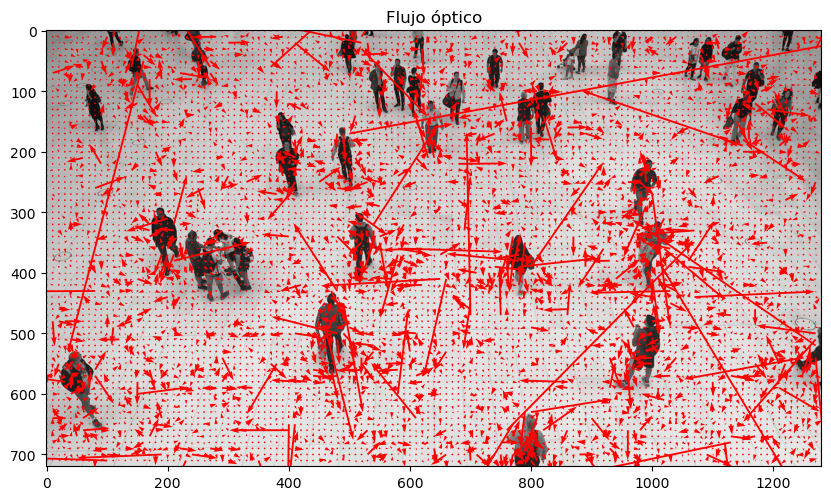

KeyboardInterrupt: 

In [ ]:
def process_video(video_path, window_size=5):
    # Cargar el video
    cap = cv.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    
    if not ret:
        print("No se pudo leer el video.")
        return
    
    # Convertir el primer frame a escala de grises
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)
    
    while True:
        # Leer el siguiente frame
        ret, next_frame = cap.read()
        if not ret:
            break
        
        next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY)
        
        # Aplicar Lucas-Kanade entre frames consecutivos
        u, v = lucas_kanade(prev_gray, next_gray, window_size)
        
        # Visualizar el flujo óptico
        step = 10
        plt.figure(figsize=(10, 10))
        plt.imshow(prev_gray, cmap='gray')
        plt.quiver(np.arange(0, u.shape[1], step),
                   np.arange(0, u.shape[0], step),
                   u[::step, ::step], v[::step, ::step], color='r')
        plt.title("Flujo óptico")
        plt.show()
        
        # Actualizar el frame anterior
        prev_gray = next_gray
    
    cap.release()

# Ejecutar el procesamiento en el video
process_video("../videos/people2.mp4", window_size=5)


## 2. Lucas-kanade y YOLO

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from handperson  import HandPerson

In [4]:
# Cargar el video
video = cv.VideoCapture("../videos/people2.mp4")
fps = video.get(cv.CAP_PROP_FPS)
status, img = video.read()
size = (img.shape[1], img.shape[0])

# Configuración para guardar el video de salida
fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('videos/video1.mp4', fourcc, 20.0, size)

# Cargar modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')


# Inicialización de seguimiento
person = HandPerson()
pos_person = 3  # Posición de la persona en el modelo YOLO
i = 0

# Parámetros para Lucas-Kanade
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

prev_points = None
prev_gray = None

while status:
    orig = img.copy()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    if i < 1:  # Detectar puntos iniciales en el primer cuadro
        # Detección de puntos clave con YOLO
        detections = model(img)
        keypoints = detections[0].keypoints
        keypoint = keypoints[pos_person]
        keypoint_coordinates = keypoint.xy[0]
        right_wrists = keypoint_coordinates[10]
        person.add(int(right_wrists[0]), int(right_wrists[1]))

        # Inicializar puntos para Lucas-Kanade
        prev_points = np.array([[right_wrists[0], right_wrists[1]]], dtype=np.float32).reshape(-1, 1, 2)
        prev_gray = img_gray
    else:
        # Rastrear con Lucas-Kanade
        if prev_points is not None:
            next_points, status, _ = cv.calcOpticalFlowPyrLK(prev_gray, img_gray, prev_points, None, **lk_params)
            if status[0] == 1:  # Punto rastreado con éxito
                x, y = int(next_points[0][0][0]), int(next_points[0][0][1])
                person.calculate_distance(x, y)

                # Dibujar un rectángulo alrededor de la posición actual
                w, h = 10, 10
                cv.rectangle(img, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (0, 255, 0))

                # Dibujar trayectoria
                for j in range(1, len(person.x)):
                    if person.x[j - 1] is not None and person.x[j] is not None:
                        cv.line(img, 
                                (person.x[j - 1], person.y[j - 1]), 
                                (person.x[j], person.y[j]), 
                                (255, 0, 0), 
                                2)

                prev_points = next_points  # Actualizar puntos
                prev_gray = img_gray  # Actualizar cuadro previo

    i += 1

    # Mostrar resultados
    cv.imshow('Tracking', img)
    video_out.write(cv.cvtColor(img, cv.COLOR_RGB2BGR))

    # Leer el siguiente cuadro
    status, img = video.read()

    if cv.waitKey(1) == 27:
        status = False

# Liberar recursos
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 551.8ms
Speed: 2.6ms preprocess, 551.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


### 2.1. Lucas-Kanade version clean code

In [10]:
# Función para obtener la posición inicial de la mano
def get_hand(img, model, person_idx=3):
    detections = model(img)
    keypoints = detections[0].keypoints
    keypoint_coordinates = keypoints[person_idx].xy[0]
    right_wrists = keypoint_coordinates[10]
    return int(right_wrists[0]), int(right_wrists[1])

In [ ]:
video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()
size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('videos/video_lucas_kanade.mp4', fourcc, 20.0, size)

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# Obtener la posición inicial de la mano
hand_point = get_hand(old_frame, model)
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

# Inicializar el seguimiento
tracking_path = [hand_point]

# Parámetros para Lucas-Kanade
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Inicializar puntos para Lucas-Kanade
prev_points = np.array([hand_point], dtype=np.float32).reshape(-1, 1, 2)

# Procesamiento del video
compute_start = time.time()

while status:
    ret, frame = video.read()
    if not ret:
        break

    # Convertir a escala de grises
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calcular el flujo óptico usando Lucas-Kanade
    next_points, status, _ = cv.calcOpticalFlowPyrLK(old_gray, gray, prev_points, None, **lk_params)
    new_tracked_points = []

    if status[0][0] == 1:  # Si el punto fue rastreado con éxito
        x, y = next_points[0][0]
        new_tracked_points.append((x, y))
        tracking_path.append((x, y))
        prev_points = next_points  # Actualizar el punto previo
    else:
        new_tracked_points = tracking_path[-1:]

    # Dibujar la trayectoria y los puntos actuales
    for i in range(1, len(tracking_path)):
        cv.line(frame,
                (int(tracking_path[i-1][0]), int(tracking_path[i-1][1])),
                (int(tracking_path[i][0]), int(tracking_path[i][1])),
                (255, 0, 0), 2)

    for (x, y) in new_tracked_points:
        cv.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Mostrar el resultado directamente en el video
    cv.imshow('Lucas-Kanade - Mano', frame)
    video_out.write(frame)

    # Actualizar frame y escala de grises
    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()



0: 384x640 7 persons, 853.3ms
Speed: 2.0ms preprocess, 853.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [12]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 3.509596347808838 seconds
Time spent: 0.058493272463480635 minutes


In [13]:
x_coordinates = [point[0] for point in tracking_path]
y_coordinates = [point[1] for point in tracking_path]
time = [i for i in range(len(tracking_path))]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

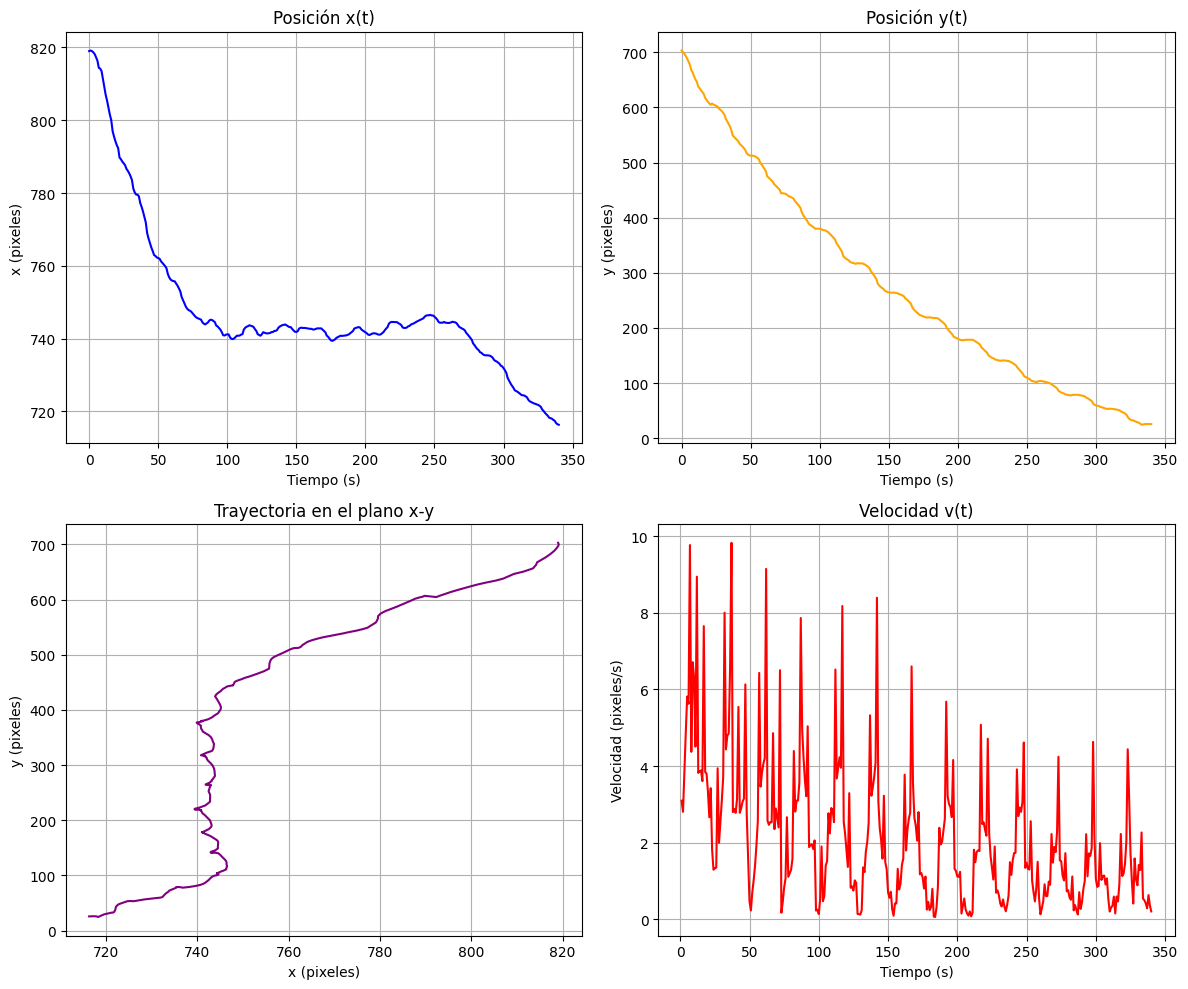

In [14]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

#### 2.2 Lucas Kanade desde 0 con clean code

In [30]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from savedata import SaveData
import time
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [3]:
# Función para obtener la posición inicial de la mano
def get_hand(img, model, person_idx=2):
    detections = model(img)
    keypoints = detections[0].keypoints
    keypoint_coordinates = keypoints[person_idx].xy[0]
    right_wrists = keypoint_coordinates[10]
    return int(right_wrists[0]), int(right_wrists[1])

In [4]:

def build_image_pyramid(img, levels=3):
    """ Construye una pirámide Gaussiana de 'levels' niveles. """
    pyramid = [img]
    for i in range(1, levels):
        pyramid.append(cv.pyrDown(pyramid[i-1]))
    return pyramid

def lucas_kanade_step(I1, I2, pts, window_size=15, max_iter=10):
    """
    Aplica una iteración de Lucas-Kanade en un solo nivel (sin pirámide).
    I1, I2: imágenes en escala de grises (float32)
    pts: puntos Nx2 (x,y)
    window_size: tamaño de la ventana
    max_iter: iteraciones para refinar
    
    Devuelve el desplazamiento (u,v) para cada punto.
    """
    half_w = window_size // 2
    
    # Gradientes de la segunda imagen (I2)
    Ix = cv.Scharr(I2, cv.CV_32F, 1, 0)
    Iy = cv.Scharr(I2, cv.CV_32F, 0, 1)
    
    # Desplazamientos iniciales
    flow = np.zeros((pts.shape[0], 2), dtype=np.float32)
    
    for i, (x, y) in enumerate(pts):
        x0, y0 = x, y
        
        # Iteraciones para refinar el cálculo
        for _ in range(max_iter):
            # Coordenadas con desplazamiento actual
            x1 = x0 + flow[i,0]
            y1 = y0 + flow[i,1]
            
            # Asegurar que la ventana esté dentro de la imagen
            x_min = int(x1 - half_w)
            x_max = int(x1 + half_w + 1)
            y_min = int(y1 - half_w)
            y_max = int(y1 + half_w + 1)
            
            if x_min < 0 or y_min < 0 or x_max > I1.shape[1] or y_max > I1.shape[0]:
                break
            
            # Extraer parches
            I1_patch = I1[y_min:y_max, x_min:x_max]
            I2_patch = I2[y_min:y_max, x_min:x_max]
            Ix_patch = Ix[y_min:y_max, x_min:x_max]
            Iy_patch = Iy[y_min:y_max, x_min:x_max]
            
            # Diferencia temporal
            It_patch = I2_patch - I1_patch
            
            # Construir matrices A y b para el sistema A * [u;v] = b
            # A = [[sum(Ix^2), sum(IxIy)],
            #      [sum(IxIy), sum(Iy^2)]]
            # b = [[-sum(IxIt)],
            #      [-sum(IyIt)]]
            
            Ix_vec = Ix_patch.flatten()
            Iy_vec = Iy_patch.flatten()
            It_vec = It_patch.flatten()
            
            A11 = np.sum(Ix_vec * Ix_vec)
            A12 = np.sum(Ix_vec * Iy_vec)
            A21 = A12
            A22 = np.sum(Iy_vec * Iy_vec)
            
            b1 = -np.sum(Ix_vec * It_vec)
            b2 = -np.sum(Iy_vec * It_vec)
            
            A = np.array([[A11, A12],
                          [A21, A22]], dtype=np.float32)
            b = np.array([b1, b2], dtype=np.float32)
            
            # Resolvemos el sistema A * delta_flow = b
            # Usamos np.linalg.lstsq para ser más robustos
            delta_flow, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
            
            # Actualizar el flujo
            flow[i] += delta_flow
            
            # Si el cambio es muy pequeño, paramos
            if np.linalg.norm(delta_flow) < 0.01:
                break
    return flow

def calcOpticalFlowPyrLK_custom(I1, I2, pts, win_size=15, max_level=3, criteria=(10), **kwargs):
    """
    Implementación from scratch aproximada de cv.calcOpticalFlowPyrLK.
    I1, I2: imágenes (grises) en float32
    pts: Nx2 array de puntos
    win_size: Tamaño de la ventana Lucas-Kanade
    max_level: número de niveles de la pirámide
    criteria: número de iteraciones por nivel
    
    Devuelve: flujo estimado para cada punto.
    """
    # Construir pirámides
    pyr1 = build_image_pyramid(I1, levels=max_level)
    pyr2 = build_image_pyramid(I2, levels=max_level)
    
    # Escalar puntos para el nivel superior (más pequeño)
    scale = 1.0 / (2 ** (max_level-1))
    pts_scaled = pts * scale
    
    # Flujo inicial en el nivel superior
    flow = np.zeros_like(pts, dtype=np.float32)
    
    # Iterar desde el nivel superior al inferior
    for level in reversed(range(max_level)):
        # Escala actual
        current_scale = 2**(level)
        
        # Escalamos los puntos iniciales más el flujo acumulado
        pts_level = (pts + flow) * (1.0 / current_scale)
        
        # Refinar el flujo en este nivel
        delta = lucas_kanade_step(pyr1[level], pyr2[level], pts_level, window_size=win_size, max_iter=criteria)
        
        # Actualizar el flujo total
        flow += delta * current_scale
    
    return flow

In [5]:
# Definir la nueva resolución deseada
target_width = 640
target_height = 480

video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()

# Redimensionar el primer frame a la resolución deseada
old_frame = cv.resize(old_frame, (target_width, target_height), interpolation=cv.INTER_AREA)
size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'mp4v')
video_out = cv.VideoWriter('./videos/video_lucas_kanade.mp4', fourcc, 20.0, size)

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# Obtener la posición inicial de la mano sobre el frame ya reescalado a la nueva resolución
hand_point = get_hand(old_frame, model)
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

# Inicializar el seguimiento
tracking_path = [hand_point]

# Parámetros para Lucas-Kanade
lk_params = dict(winSize=(15, 15),  
                 maxLevel=4,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Inicializar puntos para Lucas-Kanade
prev_points = np.array([hand_point], dtype=np.float32).reshape(-1, 1, 2)

compute_start = time.time()


while status:
    ret, frame = video.read()
    if not ret:
        break

    # Redimensionar el frame a la resolución deseada
    frame = cv.resize(frame, (target_width, target_height), interpolation=cv.INTER_AREA)

    # Convertir a escala de grises
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Convertir imágenes a float32 normalizado para la función custom (asumiendo ya la tienes implementada)
    old_gray_float = old_gray.astype(np.float32)/255.0
    gray_float = gray.astype(np.float32)/255.0

    # Extraer parámetros de lk_params
    winSize = lk_params.get('winSize', (15,15))
    maxLevel = lk_params.get('maxLevel', 2)
    criteria = lk_params.get('criteria', (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    iterations = criteria[1] if len(criteria) > 1 else 10

    # Calcular el flujo óptico con la función custom (calcOpticalFlowPyrLK_custom)
    current_points = prev_points.reshape(-1, 2)
    flow = calcOpticalFlowPyrLK_custom(old_gray_float, gray_float, current_points,
                                       win_size=winSize[0], max_level=maxLevel, criteria=iterations)

    # Sumar el flujo a los puntos previos para obtener los puntos siguientes
    next_points = prev_points + flow.reshape(-1, 1, 2)

    # Suponemos que el tracking fue exitoso si el flujo no es NaN ni infinito
    if np.all(np.isfinite(flow)):
        status = np.array([[1]], dtype=np.uint8)
    else:
        status = np.array([[0]], dtype=np.uint8)

    new_tracked_points = []
    if status[0][0] == 1:
        x, y = next_points[0][0]
        new_tracked_points.append((x, y))
        tracking_path.append((x, y))
        prev_points = next_points
    else:
        new_tracked_points = tracking_path[-1:]

    # Dibujar la trayectoria
    for i in range(1, len(tracking_path)):
        cv.line(frame,
                (int(tracking_path[i-1][0]), int(tracking_path[i-1][1])),
                (int(tracking_path[i][0]), int(tracking_path[i][1])),
                (255, 0, 0), 2)

    for (x, y) in new_tracked_points:
        cv.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Mostrar y guardar el resultado
    cv.imshow('Lucas-Kanade - Mano (Resolucion Reducida)', frame)
    video_out.write(frame)

    # Actualizar frame y escala de grises
    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()

100%|██████████| 113M/113M [00:12<00:00, 9.29MB/s] 



0: 480x640 9 persons, 1062.6ms
Speed: 4.7ms preprocess, 1062.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


In [6]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 10.204918622970581 seconds
Time spent: 0.1700819770495097 minutes


In [34]:
x_coordinates = [point[0] for point in tracking_path]
y_coordinates = [point[1] for point in tracking_path]
time = [i for i in range(len(tracking_path))]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "time": time,
    "speed": speed.tolist(),
}

savedata = SaveData(data, "tracking_lukas_kanade")
savedata.save_data()

Datos guardados en ../resultados\tracking_lukas_kanade.txt


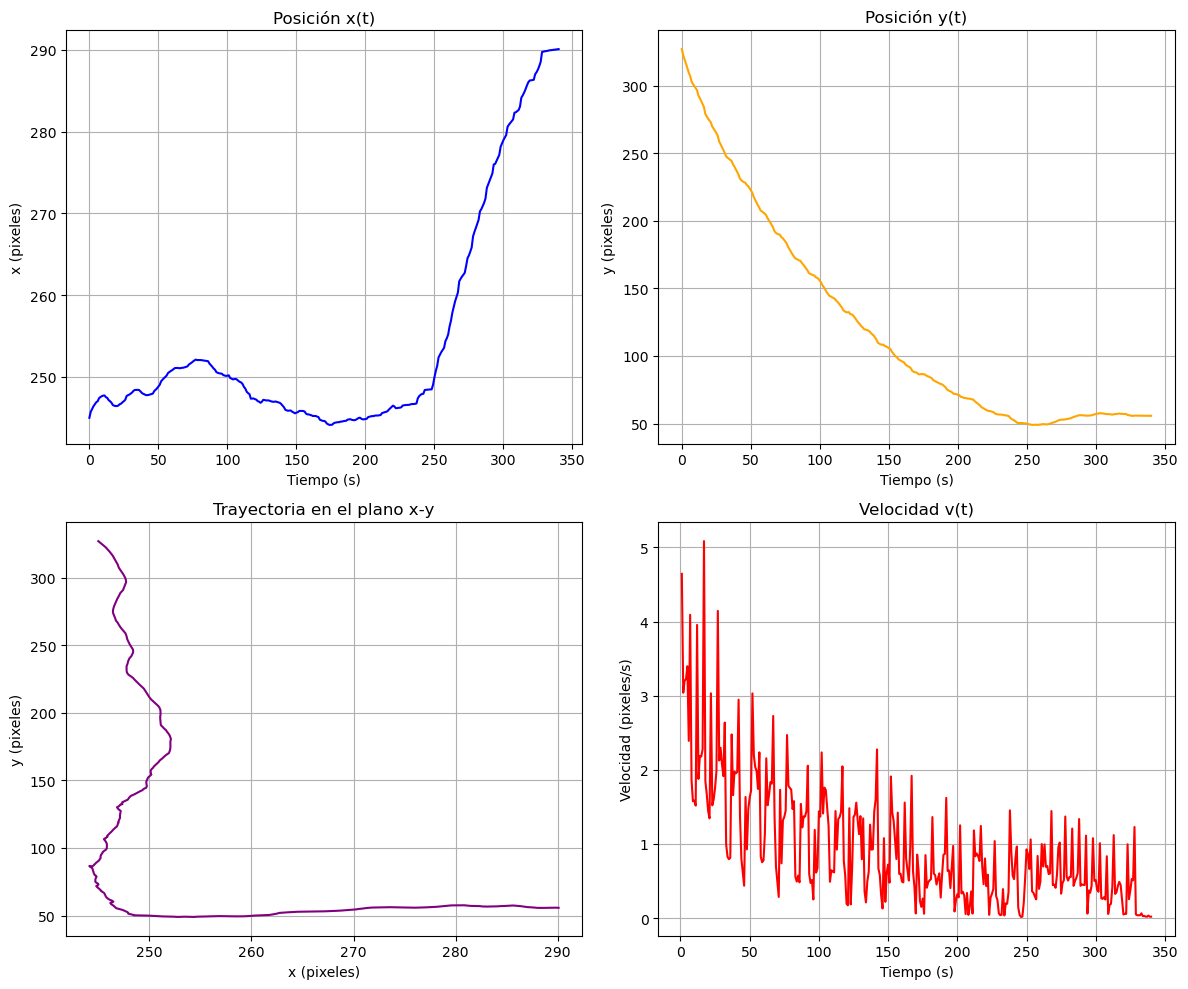

In [73]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()